RMSE: 1082.32316654093
R2 Score: 0.5690079698746089
Cross-validation RMSE: 1142.8205975439903 (+/- 18.587114836215502)
                      feature  importance
3                    Item_MRP    0.465618
8                 Outlet_Type    0.230540
2             Item_Visibility    0.124453
0                 Item_Weight    0.068426
10               Outlet_Years    0.040390
5   Outlet_Establishment_Year    0.022570
1            Item_Fat_Content    0.018751
4           Outlet_Identifier    0.014834
6                 Outlet_Size    0.007677
7        Outlet_Location_Type    0.005556
9               Item_MRP_Bins    0.001184


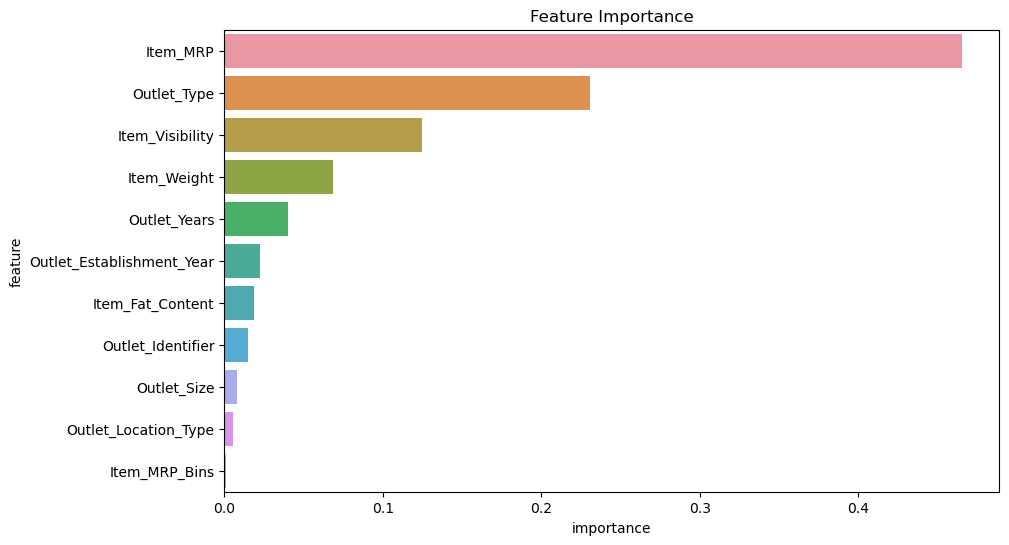

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


train_data = pd.read_csv('/Users/purabreddy/Downloads/Dmart sales analysis/train (1).csv')
test_data = pd.read_csv('/Users/purabreddy/Downloads/Dmart sales analysis/test (1).csv')

def preprocess_data(data):
    data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)
    data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)

    le = LabelEncoder()
    categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])

    data['Item_Visibility'] = np.where(data['Item_Visibility'] == 0, data['Item_Visibility'].mean(), data['Item_Visibility'])
    data['Item_MRP_Bins'] = pd.qcut(data['Item_MRP'], q=4, labels=[1, 2, 3, 4])
    data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
    
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
            'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
            'Item_MRP_Bins', 'Outlet_Years']

X = train_data[features]
y = train_data['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE: {cv_rmse.mean()} (+/- {cv_rmse.std() * 2})")


feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

test_predictions = rf_model.predict(test_data[features])